100%|██████████| 9.91M/9.91M [00:01<00:00, 6.07MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 160kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.52MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.60MB/s]


Epoch 1/5 Train Loss: 0.9936, Train Acc: 74.25% Val Loss: 0.4181, Val Acc: 88.34%
Epoch 2/5 Train Loss: 0.3704, Train Acc: 89.52% Val Loss: 0.3138, Val Acc: 90.79%
Epoch 3/5 Train Loss: 0.3137, Train Acc: 90.94% Val Loss: 0.2858, Val Acc: 91.57%
Epoch 4/5 Train Loss: 0.2818, Train Acc: 91.76% Val Loss: 0.2696, Val Acc: 91.91%
Epoch 5/5 Train Loss: 0.2563, Train Acc: 92.52% Val Loss: 0.2426, Val Acc: 92.88%
Epoch 1/5 Train Loss: 1.0017, Train Acc: 74.55% Val Loss: 0.4091, Val Acc: 88.49%
Epoch 2/5 Train Loss: 0.3771, Train Acc: 89.18% Val Loss: 0.3464, Val Acc: 89.41%
Epoch 3/5 Train Loss: 0.3172, Train Acc: 90.77% Val Loss: 0.2898, Val Acc: 91.73%
Epoch 4/5 Train Loss: 0.2826, Train Acc: 91.78% Val Loss: 0.2705, Val Acc: 91.97%
Epoch 5/5 Train Loss: 0.2557, Train Acc: 92.47% Val Loss: 0.2454, Val Acc: 93.05%
Epoch 1/5 Train Loss: 1.3422, Train Acc: 56.59% Val Loss: 0.5251, Val Acc: 86.40%
Epoch 2/5 Train Loss: 0.6257, Train Acc: 80.90% Val Loss: 0.3567, Val Acc: 89.86%
Epoch 3/5 Train 

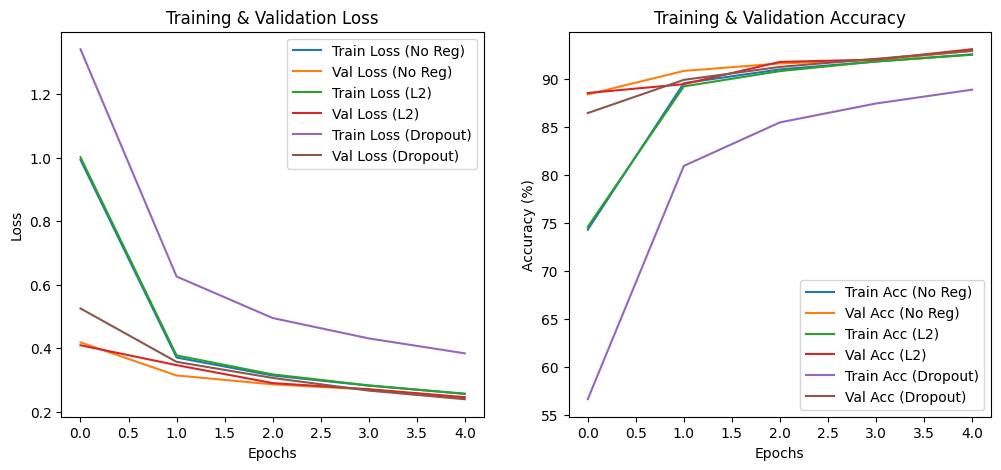

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F

# --------------------
# 1. Data Preparation
# --------------------
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_data = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
test_data = datasets.MNIST(root="./data", train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)

# --------------------
# 2. Model Definitions
# --------------------
class MLP(nn.Module):
    def __init__(self, dropout=False):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.5) if dropout else nn.Identity()

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# --------------------
# 3. Training Function
# --------------------
def train_and_evaluate(model, optimizer, epochs=5):
    train_losses, val_losses, train_accs, val_accs = [], [], [], []

    for epoch in range(epochs):
        # Training
        model.train()
        correct, total, train_loss = 0, 0, 0
        for images, labels in train_loader:
            optimizer.zero_grad()
            output = model(images)
            loss = F.cross_entropy(output, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(output, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_losses.append(train_loss / len(train_loader))
        train_accs.append(100 * correct / total)

        # Validation
        model.eval()
        correct, total, val_loss = 0, 0, 0
        with torch.no_grad():
            for images, labels in test_loader:
                output = model(images)
                loss = F.cross_entropy(output, labels)
                val_loss += loss.item()
                _, predicted = torch.max(output, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_losses.append(val_loss / len(test_loader))
        val_accs.append(100 * correct / total)

        print(f"Epoch {epoch+1}/{epochs} "
              f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accs[-1]:.2f}% "
              f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accs[-1]:.2f}%")

    return train_losses, val_losses, train_accs, val_accs

# --------------------
# 4. Experiments
# --------------------
epochs = 5

# (A) No Regularization
model_no_reg = MLP(dropout=False)
optimizer_no_reg = optim.SGD(model_no_reg.parameters(), lr=0.01)
loss_no_reg, val_loss_no_reg, acc_no_reg, val_acc_no_reg = train_and_evaluate(model_no_reg, optimizer_no_reg, epochs)

# (B) L2 Regularization (Weight Decay)
model_l2 = MLP(dropout=False)
optimizer_l2 = optim.SGD(model_l2.parameters(), lr=0.01, weight_decay=1e-4)  # L2 regularization
loss_l2, val_loss_l2, acc_l2, val_acc_l2 = train_and_evaluate(model_l2, optimizer_l2, epochs)

# (C) Dropout
model_dropout = MLP(dropout=True)
optimizer_dropout = optim.SGD(model_dropout.parameters(), lr=0.01)
loss_dropout, val_loss_dropout, acc_dropout, val_acc_dropout = train_and_evaluate(model_dropout, optimizer_dropout, epochs)

# --------------------
# 5. Visualization
# --------------------
plt.figure(figsize=(12,5))

# Loss curves
plt.subplot(1,2,1)
plt.plot(loss_no_reg, label='Train Loss (No Reg)')
plt.plot(val_loss_no_reg, label='Val Loss (No Reg)')
plt.plot(loss_l2, label='Train Loss (L2)')
plt.plot(val_loss_l2, label='Val Loss (L2)')
plt.plot(loss_dropout, label='Train Loss (Dropout)')
plt.plot(val_loss_dropout, label='Val Loss (Dropout)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

# Accuracy curves
plt.subplot(1,2,2)
plt.plot(acc_no_reg, label='Train Acc (No Reg)')
plt.plot(val_acc_no_reg, label='Val Acc (No Reg)')
plt.plot(acc_l2, label='Train Acc (L2)')
plt.plot(val_acc_l2, label='Val Acc (L2)')
plt.plot(acc_dropout, label='Train Acc (Dropout)')
plt.plot(val_acc_dropout, label='Val Acc (Dropout)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training & Validation Accuracy')
plt.legend()

plt.show()
